In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, hour, mean, month, year, to_date
from pyspark.sql.window import Window
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
#!pip install tqdm

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [6]:
spark

# Schema de données

In [7]:
schema = StructType() \
    .add("STATION", IntegerType(), False) \
    .add("DATE", TimestampType(), False) \
    .add("SOURCE", IntegerType(), True) \
    .add("LATITUDE", FloatType(), True) \
    .add("LONGITUDE", FloatType(), True) \
    .add("ELEVATION", StringType(), True) \
    .add("NAME", StringType(), True) \
    .add("REPORT_TYPE", StringType(), True) \
    .add("CALL_SIGN", StringType(), True) \
    .add("QUALITY_CONTROL", StringType(), True) \
    .add("WND", StringType(), True) \
    .add("CIG", StringType(), True) \
    .add("VIS", StringType(), True) \
    .add("TMP", StringType(), True) \
    .add("DEW", StringType(), True) \
    .add("SLP", StringType(), True) \
    .add("GA1", StringType(), True) \
    .add("GA2", StringType(), True) \
    .add("GA3", StringType(), True) \
    .add("GA4", StringType(), True) \
    .add("GF1", StringType(), True) \
    .add("MA1", StringType(), True) \
    .add("MW1", StringType(), True) \
    .add("MW2", StringType(), True) \
    .add("MW3", StringType(), True) \
    .add("OC1", StringType(), True) \
    .add("REM", StringType(), True) \
    .add("EQD", StringType(), True)

# Chargement des données

In [8]:
# station_2018 = spark.read.load("./data/2018", format="csv", header=True, schema=schema, inferSchema=False)
# station_2018.show()

In [9]:
cols_of_interest = ("STATION","DATE","SOURCE","LATITUDE","LONGITUDE","ELEVATION","NAME","REPORT_TYPE","CALL_SIGN","QUALITY_CONTROL","WND","CIG","VIS","TMP","DEW","SLP")

all_stations = spark.read.load("./data/*", format="csv", header=True, schema=schema, inferSchema=False).select(*cols_of_interest)

In [10]:
all_stations

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP
826099999,2008-01-01 00:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"280,1,N,0062,1","22000,1,9,N","024140,1,N,1","+0020,1","-0040,1","10170,1"
826099999,2008-01-01 00:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"100,1,N,0021,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10231,1"
826099999,2008-01-01 00:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-16,KDAL,V020,"360,1,N,0057,1","22000,1,9,N","016093,1,N,1","+9999,9","+9999,9","99999,9"
826099999,2008-01-01 01:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0046,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10181,1"
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"300,1,N,0067,1","22000,1,9,N","016093,1,N,1","+0030,1","-0040,1","99999,9"
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"100,1,N,0031,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10229,1"
826099999,2008-01-01 02:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0051,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10192,1"
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0020,1","-0040,1","10190,1"
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"080,1,N,0041,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10231,1"
826099999,2008-01-01 03:00:00,4,0.0,0.0,0.0,WXPOD8270,SY-MT,KFMH,V020,"300,1,N,0041,1","22000,1,9,N","016000,1,N,1","+0017,1","-0044,1","10203,1"


In [10]:
# Nombre de lignes
all_stations.count()

9573561

## Supprimer les lignes du champ TMP avec des valeurs vides OU des +9999

In [11]:
all_stations = all_stations.na.drop(how="any", subset=["TMP"]).filter(~all_stations.TMP.contains("+9999"))

## Supprimer les lignes du champ ELEVATION avec des valeurs vides OU des +9999

In [12]:
all_stations = all_stations.na.drop(how="any", subset=["ELEVATION"]).filter(~all_stations.ELEVATION.contains("+9999"))

## Supprimer les lignes du champ DEW avec des valeurs vides OU des +9999

In [13]:
all_stations = all_stations.na.drop(how="any", subset=["DEW"]).filter(~all_stations.DEW.contains("+9999"))

## Supprimer les lignes du champ WND avec des valeurs vides OU des 9999

In [14]:
all_stations = all_stations.na.drop(how="any", subset=["WND"]).filter(~all_stations.WND.contains("9999"))

## Supprimer les lignes du champ CIG avec des valeurs vides OU des 99999

In [15]:
all_stations = all_stations.na.drop(how="any", subset=["CIG"]).filter(~all_stations.CIG.contains("99999"))

In [16]:
# Nombre de lignes après le drop
all_stations.count()

5344143

In [16]:
# Le schema de données
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)



## Split de la colonne température

In [17]:
@udf(returnType=FloatType())
def extract_tmp(tmp_col: str):
    return int(tmp_col.split(',')[0].lstrip('+')) / 10

all_stations = all_stations.withColumn('temperature', extract_tmp(all_stations['TMP']))

## Split de la colonne DEW

In [18]:
@udf(returnType=FloatType())
def extract_dew(dew_col: str):
    return int(dew_col.split(',')[0].lstrip('+')) / 10

all_stations = all_stations.withColumn('precipitation', extract_dew(all_stations['DEW']))

## Split de la colonne WND

In [19]:
@udf(returnType=FloatType())
def extract_wnd(wnd_col: str):
    return int(wnd_col.split(',')[3].lstrip('+')) / 10

all_stations = all_stations.withColumn('speed_rate', extract_wnd(all_stations['WND']))

## Split de la colonne CIG

In [20]:
@udf(returnType=IntegerType())
def extract_cig(cig_col: str):
    return int(cig_col.split(',')[0])

all_stations = all_stations.withColumn('ceiling_height', extract_cig(all_stations['CIG']))

In [21]:
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- temperature: float (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- speed_rate: float (nullable = true)
 |-- ceiling_height: integer (nullable = true)



## Création du champ season

In [22]:
@udf(returnType=StringType())
def create_season(month: int):
    if month in [7, 8, 9]:
        season = 'Summer'
    elif month in [10, 11, 12]:
        season = 'Autumn'
    elif month in [1, 2, 3]:
        season = 'Winter'
    else:
        season = 'Spring'
    return season

all_stations = all_stations.withColumn('season', create_season(month("DATE")))

In [23]:
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- temperature: float (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- speed_rate: float (nullable = true)
 |-- ceiling_height: integer (nullable = true)
 |-- season: string (nullable = true)



In [24]:
all_stations

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,temperature,precipitation,speed_rate,ceiling_height,season
826099999,2008-01-01 00:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"280,1,N,0062,1","22000,1,9,N","024140,1,N,1","+0020,1","-0040,1","10170,1",2.0,-4.0,6.2,22000,Winter
826099999,2008-01-01 01:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0046,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10181,1",1.0,-4.0,4.6,22000,Winter
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"300,1,N,0067,1","22000,1,9,N","016093,1,N,1","+0030,1","-0040,1","99999,9",3.0,-4.0,6.7,22000,Winter
826099999,2008-01-01 02:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0051,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10192,1",1.0,-4.0,5.1,22000,Winter
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0020,1","-0040,1","10190,1",2.0,-4.0,4.1,22000,Winter
826099999,2008-01-01 03:00:00,4,0.0,0.0,0.0,WXPOD8270,SY-MT,KFMH,V020,"300,1,N,0041,1","22000,1,9,N","016000,1,N,1","+0017,1","-0044,1","10203,1",1.7,-4.4,4.1,22000,Winter
826099999,2008-01-01 03:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0010,1","-0030,1","10200,1",1.0,-3.0,4.1,22000,Winter
826099999,2008-01-01 04:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"999,9,V,0010,1","22000,1,9,N","024140,1,N,1","-0030,1","-0050,1","10196,1",-3.0,-5.0,1.0,22000,Winter
826099999,2008-01-01 04:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"260,1,N,0036,1","22000,1,9,N","016093,1,N,1","+0000,1","-0030,1","10207,1",0.0,-3.0,3.6,22000,Winter
826099999,2008-01-01 05:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"210,1,N,0015,1","22000,1,9,N","024140,1,N,1","-0040,1","-0050,1","10199,1",-4.0,-5.0,1.5,22000,Winter


## Moyenne des températures, elevations, speed_rates, ceiling_heights et des précipitations par année/mois/journée/saison

In [25]:
# Par année
means_by_year = all_stations.groupBy([year("DATE").alias("year")]).agg(F.round(mean("temperature"), 2).alias("mean_tmp"), F.round(mean("ELEVATION"), 2).alias("mean_elevation"), F.round(mean("speed_rate"), 2).alias("mean_speed_rate"), F.round(mean("ceiling_height"), 2).alias("mean_ceiling_height"), F.round(mean("precipitation"), 2).alias("mean_dew"))
means_by_year = means_by_year.sort("year")
means_by_year

year,mean_tmp,mean_elevation,mean_speed_rate,mean_ceiling_height,mean_dew
2000,6.5,83.99,3.97,9158.99,3.07
2002,5.1,99.39,3.78,10364.9,1.29
2004,5.34,99.69,4.13,10119.5,1.55
2006,4.66,49.06,5.17,6679.71,0.92
2008,3.81,73.26,5.02,6909.59,0.0
2010,3.03,79.17,5.17,7082.15,-0.51
2012,4.48,63.71,7.08,8738.69,0.8
2014,5.25,82.24,7.04,2883.6,1.82
2016,3.95,80.42,4.71,2751.0,0.64
2018,3.97,47.19,6.02,3987.21,0.66


In [26]:
# Par mois
means_by_month = all_stations.groupBy([year("DATE").alias("year"), month("DATE").alias("month")]).agg(F.round(mean("temperature"), 2).alias("mean_tmp"), F.round(mean("ELEVATION"), 2).alias("mean_elevation"), F.round(mean("speed_rate"), 2).alias("mean_speed_rate"), F.round(mean("ceiling_height"), 2).alias("mean_ceiling_height"), F.round(mean("precipitation"), 2).alias("mean_dew"))
means_by_month = means_by_month.sort("year", "month")
means_by_month

year,month,mean_tmp,mean_elevation,mean_speed_rate,mean_ceiling_height,mean_dew
2000,1,-0.17,84.45,4.95,9041.95,-2.73
2000,2,-0.14,85.04,4.83,9051.08,-2.75
2000,3,1.1,84.16,4.62,10068.88,-2.8
2000,4,4.33,85.19,3.69,9123.43,0.43
2000,5,9.5,84.23,3.67,12021.23,4.03
2000,6,11.77,83.83,4.0,9326.8,6.93
2000,7,14.1,81.31,3.22,8645.74,10.16
2000,8,13.63,82.84,2.99,9537.76,10.18
2000,9,10.7,85.1,3.52,10872.76,7.15
2000,10,8.66,83.85,4.26,7911.04,5.94


## Création du champ 'year'

In [27]:
all_stations = all_stations.withColumn("year", year(all_stations["DATE"]))
all_stations

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,temperature,precipitation,speed_rate,ceiling_height,season,year
826099999,2008-01-01 00:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"280,1,N,0062,1","22000,1,9,N","024140,1,N,1","+0020,1","-0040,1","10170,1",2.0,-4.0,6.2,22000,Winter,2008
826099999,2008-01-01 01:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0046,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10181,1",1.0,-4.0,4.6,22000,Winter,2008
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"300,1,N,0067,1","22000,1,9,N","016093,1,N,1","+0030,1","-0040,1","99999,9",3.0,-4.0,6.7,22000,Winter,2008
826099999,2008-01-01 02:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0051,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10192,1",1.0,-4.0,5.1,22000,Winter,2008
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0020,1","-0040,1","10190,1",2.0,-4.0,4.1,22000,Winter,2008
826099999,2008-01-01 03:00:00,4,0.0,0.0,0.0,WXPOD8270,SY-MT,KFMH,V020,"300,1,N,0041,1","22000,1,9,N","016000,1,N,1","+0017,1","-0044,1","10203,1",1.7,-4.4,4.1,22000,Winter,2008
826099999,2008-01-01 03:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0010,1","-0030,1","10200,1",1.0,-3.0,4.1,22000,Winter,2008
826099999,2008-01-01 04:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"999,9,V,0010,1","22000,1,9,N","024140,1,N,1","-0030,1","-0050,1","10196,1",-3.0,-5.0,1.0,22000,Winter,2008
826099999,2008-01-01 04:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"260,1,N,0036,1","22000,1,9,N","016093,1,N,1","+0000,1","-0030,1","10207,1",0.0,-3.0,3.6,22000,Winter,2008
826099999,2008-01-01 05:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"210,1,N,0015,1","22000,1,9,N","024140,1,N,1","-0040,1","-0050,1","10199,1",-4.0,-5.0,1.5,22000,Winter,2008


## Longitude et latitude par station

In [28]:
annee = int(input("Quelle année? : "))
longitude_latitude_par_station = all_stations.filter(all_stations.year == annee).groupBy(["STATION"]).agg(mean("LATITUDE").alias("lat"), mean("LONGITUDE").alias("long"))
longitude_latitude_par_station.show()

Quelle année? :  2018


+----------+-----------------+------------------+
|   STATION|              lat|              long|
+----------+-----------------+------------------+
|1052099999|70.68333435058594|23.683332443237305|
|1023099999|69.05575561523438|18.540355682373047|
|1025099999|69.68333435058594| 18.91891860961914|
|1059099999|70.06881713867188| 24.97348976135254|
|1010099999| 69.2925033569336|16.144166946411133|
|1008099999|78.24610900878906|15.465556144714355|
|1087599999|59.56666564941406|2.2166666984558105|
|1087699999|66.01667022705078| 8.083333015441895|
|1049099999|69.97611236572266|23.371667861938477|
|1044099999| 70.4866714477539| 22.13974380493164|
|1046099999| 69.7868423461914|20.959444046020508|
|1083099999|70.86666870117188| 29.03333282470703|
|1086099999|70.60025787353516|29.692678451538086|
|1074099999|71.03333282470703| 27.83333396911621|
|1028099999|74.51667022705078|19.016666412353516|
|1026099999| 69.6500015258789|18.933332443237305|
|1068099999|71.01667022705078|25.983333587646484|


In [29]:
longitude_latitude_par_station.count()

29

In [ ]:
filtre_norvege = longitude_latitude_par_station.filter(longitude_latitude_par_station.long >= 5).filter(longitude_latitude_par_station.long <= 12).filter(longitude_latitude_par_station.lat >= 57).filter(longitude_latitude_par_station.lat <= 65)
filtre_norvege

In [ ]:
# Par jour, pour l'année choisie et pour une station choisie
num_station = int(input("Quelle station ? : "))
means_by_day = all_stations.filter(all_stations.year == annee).filter(all_stations.STATION == num_station).groupBy([to_date("DATE").cast("date").alias("date")]).agg(F.round(mean("temperature"), 2).alias("mean_tmp"), F.round(mean("ELEVATION"), 2).alias("mean_elevation"), F.round(mean("speed_rate"), 2).alias("mean_speed_rate"), F.round(mean("ceiling_height"), 2).alias("mean_ceiling_height"), F.round(mean("precipitation"), 2).alias("mean_dew"))
means_by_day = means_by_day.sort("date")
means_by_day.show(365)

In [33]:
means_by_day.count()

296

# Apprentissage

## Définition features/valeur cible + splits

In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Load training data
training = means_by_day

vectorAssembler = VectorAssembler(inputCols = ["mean_tmp", "mean_elevation", "mean_speed_rate", "mean_ceiling_height"], outputCol = 'features')
v_training = vectorAssembler.transform(training)
v_training = v_training.select(['features', 'mean_wnd'])
v_training.show(3)

NameError: name 'means_by_day' is not defined

## 1) Linear regression

In [36]:
lr = LinearRegression(featuresCol = 'features', labelCol='mean_wnd', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [1.0994581813759376,0.0,0.0,-0.0003549470170994134]
Intercept: -4.423823011597642


### Viz des corrélations entre les features et la valeur cible

In [77]:
traindf=training.toPandas()
traindf

,date,mean_tmp,mean_elevation,mean_speed_rate,mean_ceiling_height,mean_dew
0,2016-01-01,7.67,0.0,15.27,2438.00,-1.00
1,2016-01-04,-3.00,0.0,11.85,610.00,-10.00
2,2016-01-05,-0.33,0.0,10.30,437.00,-6.33
3,2016-01-06,1.00,0.0,8.50,495.25,-1.75
4,2016-01-07,-0.50,0.0,8.00,610.00,-7.50
...,...,...,...,...,...,...
291,2016-12-27,4.25,0.0,14.42,1257.25,-4.25
292,2016-12-28,8.00,0.0,24.20,739.25,5.75
293,2016-12-29,6.33,0.0,8.57,477.67,4.33
294,2016-12-30,6.25,0.0,23.03,746.75,4.00


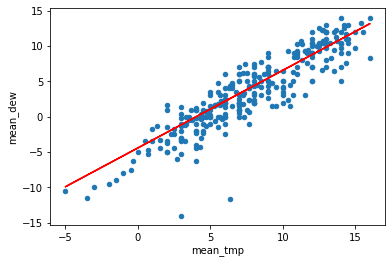

In [78]:
# Temperature
traindf.plot.scatter('mean_tmp','mean_wnd')
plt.plot(traindf['mean_wnd'], (1.0994581813759376*traindf['mean_wnd']) -4.423823011597642, color='red')

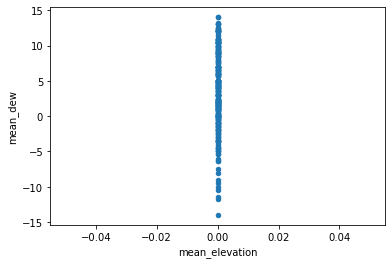

In [90]:
# Elevation
traindf.plot.scatter('mean_elevation','mean_wnd')
plt.plot(traindf['mean_elevation'], (0*traindf['mean_elevation']) -4.423823011597642, color='red')

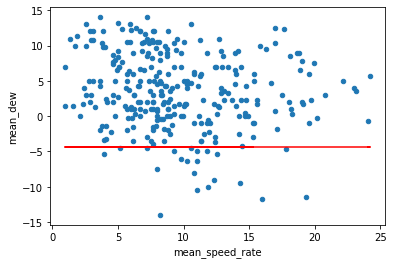

In [89]:
# Speed rate
traindf.plot.scatter('mean_speed_rate','mean_wnd')
plt.plot(traindf['mean_speed_rate'], (0*traindf['mean_speed_rate']) -4.423823011597642, color='red')

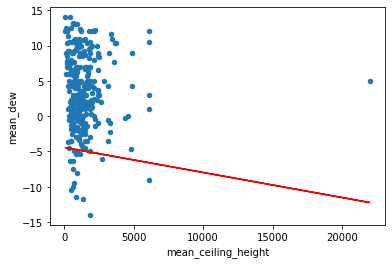

In [86]:
# Ceiling height
traindf.plot.scatter('mean_ceiling_height','mean_wnd')
plt.plot(traindf['mean_ceiling_height'], (-0.0003549470170994134*traindf['mean_ceiling_height']) - 4.423823011597642, color='red')

In [38]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 2.175821
r2: 0.828045


In [39]:
train_df.describe().show()

+-------+------------------+
|summary|          mean_dew|
+-------+------------------+
|  count|               209|
|   mean|3.5849760765550243|
| stddev| 5.259647283106932|
|    min|             -14.0|
|    max|              14.0|
+-------+------------------+



In [102]:
lr_predictions = lrModel.transform(test_df)
lr_predictions.select("prediction","mean_wnd","features").show()

+-------------------+--------+--------------------+
|         prediction|mean_dew|            features|
+-------------------+--------+--------------------+
| -7.938715236156097|   -10.0|[-3.0,0.0,11.85,6...|
| -5.190069782716252|    -7.5|[-0.5,0.0,8.0,610.0]|
|-2.2161168122173036|    -4.5|[2.5,0.0,5.15,152...|
| -4.415033174969179|    -3.5|[0.5,0.0,7.5,1524.0]|
|-3.1532754700245342|   -3.25|[1.5,0.0,4.12,106...|
|-2.8741047431205935|    -5.0|[2.0,0.0,11.8,182...|
| 2.6231861637590947|     5.0|[7.0,0.0,6.7,1829.0]|
| 3.2184323114348112|     6.0|[7.0,0.0,11.3,152.0]|
| 1.6319868225984786|    -2.5|[6.0,0.0,14.2,152...|
|  2.066862266923719|  -11.67|[6.33,0.0,15.97,1...|
|-2.3330483565454445|   -3.67|[2.0,0.0,12.37,30...|
| -3.754967346100476|   -1.33|[1.33,0.0,3.77,22...|
|-2.1500547476373013|    -2.5|[2.25,0.0,11.57,5...|
| 1.7248473869694863|    2.25|[5.75,0.0,19.7,48...|
|-0.9249551869458439|     0.0|[3.33,0.0,9.97,45...|
|-0.6392450969321506|    -1.0|[4.5,0.0,11.8,327...|
|-1.34196614

In [103]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mean_wnd",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

test_result = lrModel.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

R Squared (R2) on test data = 0.799675
Root Mean Squared Error (RMSE) on test data = 2.52172


## 2) Decision tree regression

In [104]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features", labelCol = 'mean_wnd')

In [105]:
# Train model
dt_model = dt.fit(train_df)

In [107]:
# Make test predictions
dt_predictions = dt_model.transform(test_df)
dt_predictions.select("prediction","mean_wnd","features").show()

+------------------+--------+--------------------+
|        prediction|mean_dew|            features|
+------------------+--------+--------------------+
|             -10.5|   -10.0|[-3.0,0.0,11.85,6...|
|             -6.33|    -7.5|[-0.5,0.0,8.0,610.0]|
|-4.393636363636364|    -4.5|[2.5,0.0,5.15,152...|
|-4.393636363636364|    -3.5|[0.5,0.0,7.5,1524.0]|
|-4.393636363636364|   -3.25|[1.5,0.0,4.12,106...|
|-4.393636363636364|    -5.0|[2.0,0.0,11.8,182...|
|2.4165384615384613|     5.0|[7.0,0.0,6.7,1829.0]|
|3.8206666666666664|     6.0|[7.0,0.0,11.3,152.0]|
|0.7287499999999998|    -2.5|[6.0,0.0,14.2,152...|
|0.7287499999999998|  -11.67|[6.33,0.0,15.97,1...|
|            -1.725|   -3.67|[2.0,0.0,12.37,30...|
|-4.393636363636364|   -1.33|[1.33,0.0,3.77,22...|
|            -1.725|    -2.5|[2.25,0.0,11.57,5...|
|3.8206666666666664|    2.25|[5.75,0.0,19.7,48...|
|             -0.15|     0.0|[3.33,0.0,9.97,45...|
|           -0.4575|    -1.0|[4.5,0.0,11.8,327...|
|            -1.725|    -1.0|[3

In [116]:
# Importance des features dans la prédiction
dt_model.featureImportances

SparseVector(4, {0: 0.9458, 2: 0.0152, 3: 0.039})

In [117]:
# Select (prediction, true label) and compute test error
dt_evaluator = RegressionEvaluator(
    labelCol="mean_wnd", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

dt_evaluator_2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mean_wnd",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator_2.evaluate(dt_predictions))

Root Mean Squared Error (RMSE) on test data = 2.52899
R Squared (R2) on test data = 0.798518


## 3) Random forest regression

In [111]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", labelCol = 'mean_dew')

In [112]:
# Train model
rf_model = rf.fit(train_df)

In [113]:
# Make test predictions
rf_predictions = rf_model.transform(test_df)
rf_predictions.select("prediction","mean_dew","features").show()

+-------------------+--------+--------------------+
|         prediction|mean_dew|            features|
+-------------------+--------+--------------------+
| -6.929610286040125|   -10.0|[-3.0,0.0,11.85,6...|
| -5.523016971313915|    -7.5|[-0.5,0.0,8.0,610.0]|
|-2.1154569668739107|    -4.5|[2.5,0.0,5.15,152...|
|-3.2241107962389903|    -3.5|[0.5,0.0,7.5,1524.0]|
|-2.4007976739446177|   -3.25|[1.5,0.0,4.12,106...|
| -3.036402646670731|    -5.0|[2.0,0.0,11.8,182...|
|  2.298538965851512|     5.0|[7.0,0.0,6.7,1829.0]|
| 5.0511559910677555|     6.0|[7.0,0.0,11.3,152.0]|
|  1.768620587063933|    -2.5|[6.0,0.0,14.2,152...|
| 1.6457772262580725|  -11.67|[6.33,0.0,15.97,1...|
|-1.8649492951696711|   -3.67|[2.0,0.0,12.37,30...|
|-3.0246533557627995|   -1.33|[1.33,0.0,3.77,22...|
| -2.445254474873688|    -2.5|[2.25,0.0,11.57,5...|
|  2.054159216430368|    2.25|[5.75,0.0,19.7,48...|
|  -1.78306374405412|     0.0|[3.33,0.0,9.97,45...|
|-0.3105980460399681|    -1.0|[4.5,0.0,11.8,327...|
| -1.7207589

In [114]:
# Importance des features dans la prédiction
rf_model.featureImportances

SparseVector(4, {0: 0.8515, 2: 0.0912, 3: 0.0572})

In [115]:
# Select (prediction, true label) and compute test error
rf_evaluator = RegressionEvaluator(
    labelCol="mean_dew", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rf_evaluator_2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mean_dew",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator_2.evaluate(rf_predictions))

Root Mean Squared Error (RMSE) on test data = 2.40113
R Squared (R2) on test data = 0.818376


## 4) Gradient-boosted tree regression

In [119]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Train a GBT model.
gbt = GBTRegressor(featuresCol="features", labelCol = 'mean_dew')

In [120]:
# Train model
gbt_model = gbt.fit(train_df)

In [121]:
# Make test predictions
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("prediction","mean_dew","features").show()

+--------------------+--------+--------------------+
|          prediction|mean_dew|            features|
+--------------------+--------+--------------------+
| -10.364852115714838|   -10.0|[-3.0,0.0,11.85,6...|
|  -7.805828734496676|    -7.5|[-0.5,0.0,8.0,610.0]|
|  -6.724708834510114|    -4.5|[2.5,0.0,5.15,152...|
|  -7.543558040512776|    -3.5|[0.5,0.0,7.5,1524.0]|
| -3.7269107336792073|   -3.25|[1.5,0.0,4.12,106...|
| -11.113932645425331|    -5.0|[2.0,0.0,11.8,182...|
|    2.57764215462737|     5.0|[7.0,0.0,6.7,1829.0]|
|   4.261332389035433|     6.0|[7.0,0.0,11.3,152.0]|
|  0.8389181680670837|    -2.5|[6.0,0.0,14.2,152...|
| 0.41451726178317855|  -11.67|[6.33,0.0,15.97,1...|
| 0.46715332158095435|   -3.67|[2.0,0.0,12.37,30...|
|  -3.036428832405461|   -1.33|[1.33,0.0,3.77,22...|
| -3.6987319864941277|    -2.5|[2.25,0.0,11.57,5...|
|   3.430158800348997|    2.25|[5.75,0.0,19.7,48...|
|  -0.640522147711143|     0.0|[3.33,0.0,9.97,45...|
|-0.02271724706670109|    -1.0|[4.5,0.0,11.8,3

In [122]:
# Importance des features dans la prédiction
gbt_model.featureImportances

SparseVector(4, {0: 0.6888, 2: 0.1148, 3: 0.1965})

In [123]:
# Select (prediction, true label) and compute test error
gbt_evaluator = RegressionEvaluator(
    labelCol="mean_dew", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator_2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mean_dew",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator_2.evaluate(gbt_predictions))

Root Mean Squared Error (RMSE) on test data = 2.84151
R Squared (R2) on test data = 0.745646


## Conclusion
On a trouvé la valeur moyenne des précipitations pour le "01/01/2016" dans la ville la plus proche de la station puisqu'elle est en mer : 2.5° réel contre "-0.94°" prédit avec la régression linéaire et "°" avec le decision tree.


In [117]:
# viz = lr_predictions.select("prediction","mean_dew","features").toPandas()
# viz
# viz.plot.scatter("mean_dew","features")

## Choses à faire


0) Faire valider le 1er modele par Sayf
1) Arrondir toutes les valeurs
2) Refaire le split (train/test)
3) D'autres algos : bataille d'I.A.
4) Voir d'autres prédictions prtinentes à faire
Questions:
- Prédictions sur train ? -> sur le test
- features importances : 